# Research sandbox

In [1]:
import json
import os
import warnings
import zipfile
import powerlaw

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
from tqdm.notebook import tqdm

In [ ]:
from numpy import array, degrees, diff, mean, nan, sign, where
from math import cos, sin
from numpy.linalg import norm
from powerlaw import pdf, power_law_ks_distance
from scipy.optimize import minimize
from scipy.stats import linregress

In [ ]:
from pNeuma_simulator import params
from pNeuma_simulator.animations import ring
from pNeuma_simulator.gang import decay
from pNeuma_simulator.initialization import ov

In [5]:
warnings.filterwarnings("ignore")
rcParams.update(
    {
        "pdf.fonttype": 42,
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial", "Helvetica"],
        "mathtext.fontset": "stix",
        "mathtext.default": "regular",
        "font.size": 7,
        "axes.titlesize": 7,
        "xtick.labelsize": 6,
        "ytick.labelsize": 6,
        "axes.linewidth": 0.25,
        "xtick.major.width": 0.25,
        "ytick.major.width": 0.25,
        "xtick.minor.width": 0.25,
        "ytick.minor.width": 0.25,
    }
)
# LaTeX packages
plt.rc("text", usetex=False)
plt.rc(
    "text.latex",
    preamble=r"\usepackage{amsmath}",
)
plt.rc("text.latex", preamble=r"\usepackage{gensymb}")
dark_blue = "#1964B0"
dark_teal = "#008A69"
vermilion = "#DB5829"
orange = "#F4A637"
maroon = "#894B45"
dark_purple = "#882D71"
light_purple = "#D2BBD7"
grey = "#DEDEDE"

In [6]:
path = "./output/"
os.makedirs(path, exist_ok=True)

## Simulated powerlaw distribution

In [7]:
verbose = True
howmany = 8
l_ttc = []
for permutation in [(14, 2), (14, 4), (14, 6), (14, 8)]:
    with zipfile.ZipFile(f"{path}{permutation}_r.zip", "r") as ziph:
        # ziph is zipfile handle
        for filename in ziph.namelist():
            if filename.endswith(").jsonl"):
                # Opening JSON file
                with ziph.open(filename, "r") as openfile:
                    # Reading from JSON file
                    # https://pythonspeed.com/articles/json-memory-streaming/
                    # for n, item in enumerate(tqdm(ijson.items(openfile, "item"))):
                    for n, line in enumerate(tqdm(openfile)):
                        item = json.loads(line)
                        if n < howmany:
                            # items.append(item)
                            if isinstance(item[0], list):
                                for _, agents in enumerate(item[0]):
                                    for agent in agents:
                                        ttc = agent["ttc"]
                                        if ttc:
                                            l_ttc.append(agent["ttc"])
                        else:
                            break
                    # items = json.load(openfile)
                    if verbose:
                        print(openfile.name)

0it [00:00, ?it/s]

(14, 2).jsonl


0it [00:00, ?it/s]

(14, 4).jsonl


0it [00:00, ?it/s]

(14, 6).jsonl


0it [00:00, ?it/s]

(14, 8).jsonl


In [8]:
ttc_data = array(l_ttc).astype(float)
len(ttc_data)

3833237

In [9]:
results = powerlaw.Fit(ttc_data, xmin=18.0)
results.xmin, results.sigma, results.alpha

(18.0, 0.0006119208985758025, 1.7846410453462815)

In [10]:
ks = power_law_ks_distance(ttc_data, results.alpha, results.xmin)
ks

0.0061051008021348885

In [11]:
edges, hist = pdf(ttc_data, linear_bins=True, xmin=results.xmin, xmax=1e4)
bin_centers = (edges[1:] + edges[:-1]) / 2.0
hist[hist == 0] = nan

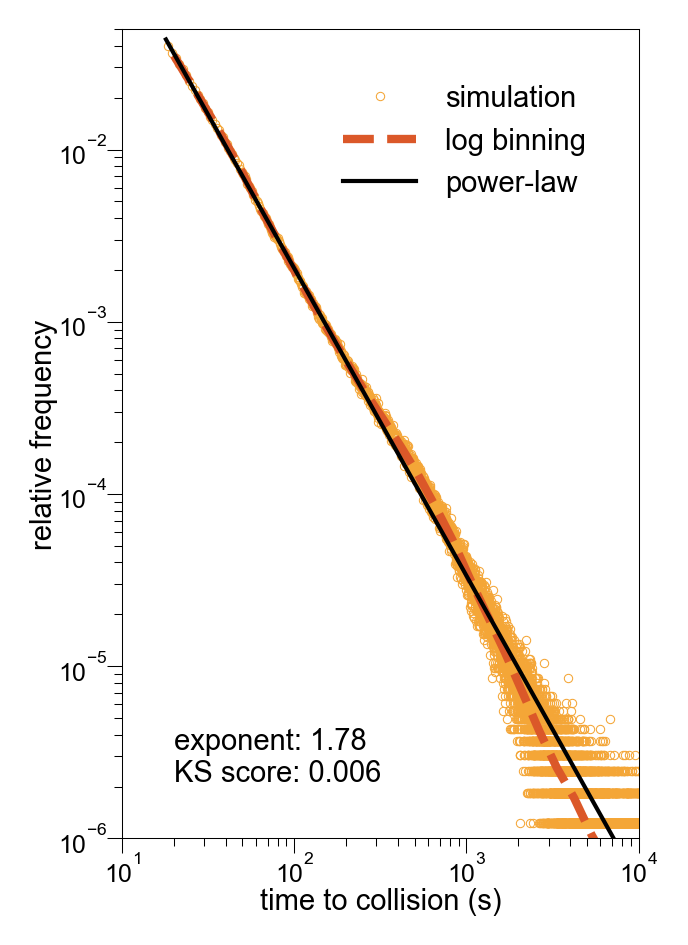

In [ ]:
fig, ax = plt.subplots(figsize=(5.25 * params.cm, 7.5 * params.cm), dpi=300)
ax.set_aspect("equal")

ax.plot(
    bin_centers,
    hist,
    color=orange,
    lw=0,
    marker=".",
    markerfacecolor="none",
    markeredgewidth=0.25,
    ms=4,
    ls="-",
    label="simulation",
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_yscale("log")
results.plot_pdf(ax=ax, linear_bins=False, c=vermilion, lw=2, ls="--", label="log binning")
results.power_law.plot_pdf(c="k", linestyle="-", lw=1, ax=ax, label="power-law")
ax.set_ylabel("relative frequency", labelpad=0)
ax.set_xlabel("time to collision (s)", labelpad=0)
ax.tick_params(axis="x", pad=0)
ax.tick_params(axis="y", pad=0)
ax.set_xlim(1e1, 1e4)
ax.set_ylim(1e-6, 5e-2)
ax.legend(
    frameon=False,
    borderpad=0,
    handletextpad=1,
    handlelength=2.5,
    fontsize=7,
    loc=2,
    bbox_to_anchor=(0.4, 0.95),
)
ax.text(
    0.1,
    0.1,
    f"exponent: {round(results.alpha,2)}\nKS score: {round(ks,3)}",
    fontsize=7,
    ha="left",
    va="center",
    transform=ax.transAxes,
)
fig.tight_layout(pad=0)
plt.savefig(
   "./output/figures/ttc_sim.pdf",
   format="pdf",
   transparent=True,
)
plt.show()

## Phase-transition

In [13]:
n_cars = 12
n_moto = 6
permutation = (n_cars, n_moto)

In [14]:
# def loader(permutation, verbose=True):
verbose = True
items = []
with zipfile.ZipFile(f"{path}{permutation}_r.zip", "r") as ziph:
    # ziph is zipfile handle
    for filename in ziph.namelist():
        if filename.endswith(").jsonl"):
            # Opening JSONL file
            with ziph.open(filename, "r") as openfile:
                # Reading from JSONL file
                # https://stackoverflow.com/questions/2081836/
                for i, line in enumerate(tqdm(openfile)):
                    item = json.loads(line)
                    if isinstance(item[0], list):
                        items.append(item)
                if verbose:
                    print(openfile.name)
#   return items

0it [00:00, ?it/s]

(12, 6).jsonl


In [32]:
NU = 1.096854  # theoretical exponent for directed percolation in 1D

In [33]:
def loss(x, y, x_star):
    renorm = np.abs(x - x_star)
    slope, _, _, _, _ = linregress(np.log(renorm)[y > 0], np.log(y[y > 0]))
    return abs(NU - slope)

In [34]:
def fit(x, y):
    # https://stackoverflow.com/questions/3843017/
    zero_crossings = where(diff(sign(y)))[0]
    x0 = x[zero_crossings[0]]
    # https://stackoverflow.com/questions/24767191/
    res = minimize(lambda x_star: loss(x, y, x_star), method="Nelder-Mead", x0=x0)
    popt = res.x[0]
    return popt

In [35]:
path = "./output/"
os.makedirs(path, exist_ok=True)
with open(f"{path}results_r.json") as openfile:
    results = json.load(openfile)

In [36]:
(
    x,
    y,
    _,
    _,
    _,
) = results[
    str(permutation)
]["percolation"]
x, y = array(x), array(y)
T_c = fit(x, y)
T_c

41.484901428222656

In [37]:
def inner_loop(frame, v_max):
    deg_range = []
    vel_car = []
    vel_x = []
    vel_y = []
    for j, _ in enumerate(frame):
        speed = frame[j]["speed"]
        theta = frame[j]["theta"]
        if j <= 2 * n_cars - 1:
            vel_car.append(speed / v_max[j])
        else:
            alphas = decay(speed, theta)
            degs = degrees(alphas)
            deg_range.append(degs[0] - degs[-1])
            vel_x.append(speed * cos(theta) / v_max[j])
            vel_y.append(speed * sin(theta) / v_max[j])
        phi_cars = mean(vel_car)
        phi_moto = norm([sum(vel_x), sum(vel_y)]) / n_moto
    return deg_range, phi_cars, phi_moto

In [38]:
start = int(len(item[0]) * 2 / 3 - 1)
start

5999

In [39]:
l_n = []
for n, item in enumerate(items):
    if isinstance(item[0], list):
        l_T = []
        l_DPhi = []
        frames = []
        n_veh = 2 * n_cars + n_moto
        lam = np.empty(shape=n_veh, dtype=float)
        v0 = np.empty(shape=n_veh, dtype=float)
        s0 = np.empty(shape=n_veh, dtype=float)
        for t, frame in enumerate(item[0]):
            if t == 0:
                for j, _ in enumerate(frame):
                    v0[j] = frame[j]["v0"]
                    lam[j] = frame[j]["lam"]
                    s0[j] = frame[j]["s0"]
            v_max = ov(params.d_max, lam, v0, s0)
            if t > start:
                deg_range, phi_cars, phi_moto = inner_loop(frame, v_max)
                if round(mean(deg_range)) == int(2 * T_c):
                    frames.append(t)
                    l_T.append(mean(deg_range))
                    l_DPhi.append(phi_moto - phi_cars)
        l_T = np.round(l_T) / 2
        if len(l_T) > 0:
            print(n, len(l_T))
            l_n.append(n)

0 23
1 46
3 133
4 72
9 81
10 50
12 38
18 72
19 64
21 106
23 8
24 51
25 59
29 61
30 3
32 33
34 76
35 13
38 115
42 35
44 39
46 79
47 77
49 37
51 10
52 34
53 57
56 19
57 111
58 8
59 120
60 86
62 23
66 49
68 9
69 55
74 79
84 84
89 143
91 53
92 45
93 110
96 121
97 62
100 60
102 6
103 100
104 49
105 100
108 41
115 80
116 24
117 48
118 47
120 5
124 72
125 78
126 29
130 105
136 79
137 16
139 23
140 14
142 63
145 32
148 39
149 62
152 46
153 42
155 13
157 119
159 6
162 50
163 127
171 28
175 112
179 41
182 75
186 67
188 79
190 36
195 98
197 33
198 39
201 26
205 124
206 47
207 4
209 115
210 102
213 72
215 83
218 40
219 158
221 98
223 44
225 61
226 39
227 65
230 79
231 24
236 148
241 12
242 43
244 24
248 25
250 36
252 107
257 46
263 93
269 77
275 44
277 26
278 16
282 66
284 12


In [292]:
start = 0
item = items[58]

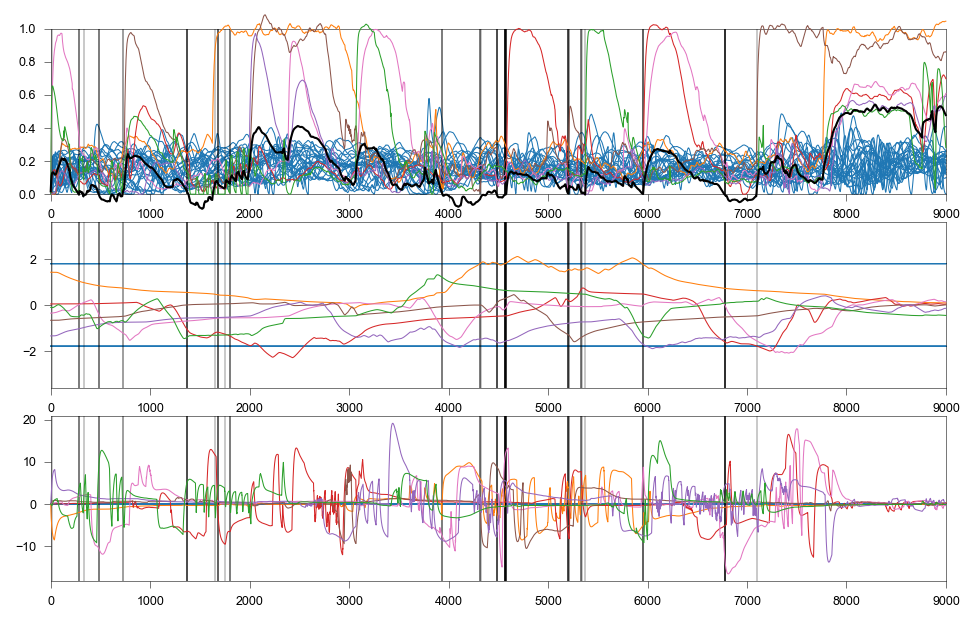

In [293]:
fig, axs = plt.subplots(3, 1, figsize=(16 * params.cm, 10 * params.cm), dpi=150)
n_veh = 2 * n_cars + n_moto
lam = np.empty(shape=n_veh, dtype=float)
v0 = np.empty(shape=n_veh, dtype=float)
s0 = np.empty(shape=n_veh, dtype=float)
frame = item[0][0]
for j, _ in enumerate(frame):
    v0[j] = frame[j]["v0"]
    lam[j] = frame[j]["lam"]
    s0[j] = frame[j]["s0"]
v_max = ov(params.d_max, lam, v0, s0)
ar = array(item[0])
for i in range(ar.shape[1]):
    speeds = []
    lateral = []
    thetas = []
    for d in ar[start::1, -(i + 1)]:
        speed = d["speed"] / v_max[-(i + 1)]
        speeds.append(speed)
        y = d["pos"][1]
        lateral.append(y)
        theta = d["theta"]
        thetas.append(degrees(theta))
    if i <= n_moto - 1:
        zorder = 10
        c = "tab:orange"
        if i == 1:
            c = "tab:red"
            zorder = 100
        elif i == 2:
            c = "tab:pink"
            zorder = 100
        elif i == 3:
            c = "tab:brown"
            zorder = 100
        elif i == 4:
            c = "tab:purple"
            zorder = 100
        elif i == 5:
            c = "tab:green"
            zorder = 100
    else:
        zorder = 0
        c = "tab:blue"
    axs[0].plot(speeds, c=c, lw=0.5, clip_on=False, zorder=zorder)
    axs[1].plot(lateral, c=c, lw=0.5, clip_on=False, zorder=zorder)
    axs[2].plot(thetas, c=c, lw=0.5, clip_on=False, zorder=zorder)
if n_moto > 0:
    l_DPhi = []
    l_T = []
    for t, frame in enumerate(item[0]):
        if t > start:
            deg_range, phi_cars, phi_moto = inner_loop(frame, v_max)
            l_DPhi.append(phi_moto - phi_cars)
            temperature = round(mean(deg_range)) / 2
            T_r = temperature - int(T_c)
            l_T.append(T_r)
            if T_r == 0:
                axs[0].axvline(t - start, c="k", ls="-", lw=0.2)
                axs[1].axvline(t - start, c="k", ls="-", lw=0.2)
                axs[2].axvline(t - start, c="k", ls="-", lw=0.2)
                # print(t - start)
    axs[0].plot(l_DPhi, c="k", lw=1, clip_on=False, zorder=100)
axs[2].set_xlim(0, ar.shape[0])  # - (start + 1))
axs[1].set_xlim(0, ar.shape[0])  # - (start + 1))
axs[0].set_xlim(0, ar.shape[0])  # - (start + 1))
axs[0].set_ylim(0, 1)
axs[1].set_ylim(-params.lane, params.lane)
fig.tight_layout(pad=0)

In [332]:
print(np.argmin(l_T), min(l_T))

8954 -29.0


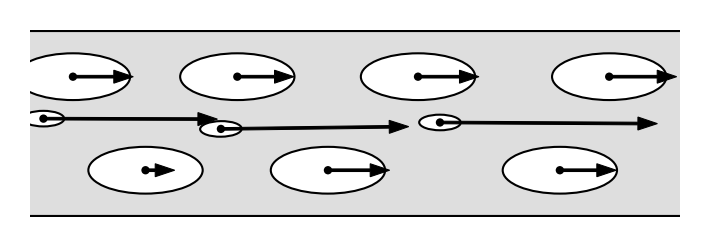

In [322]:
item = items[58]
xmin = -5.5
xmax = 19.5
t = 8954
fig, ax = plt.subplots(figsize=(5.5 * params.cm, 2 * params.cm), dpi=300)
ax.set_aspect("equal")
ring(t, n_cars, item[0], ax)
ax.set_xlim(xmin, xmax)
ax.tick_params(axis="both", direction="in", pad=0)
ax.axvspan(xmin, xmax, facecolor=grey, zorder=-1)
ax.set_axis_off()
plt.tight_layout(pad=0)
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(
    "./output/figures/absorbing.pdf",
    format="pdf",
    transparent=True,
)

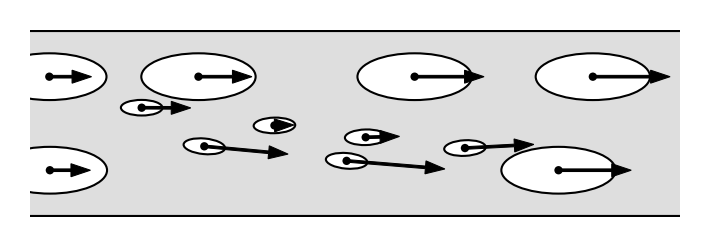

In [321]:
item = items[0]
xmin = -9
xmax = 16
t = 2283
fig, ax = plt.subplots(figsize=(5.5 * params.cm, 2 * params.cm), dpi=300)
ax.set_aspect("equal")
ring(t, n_cars, item[0], ax)
ax.set_xlim(xmin, xmax)
ax.tick_params(axis="both", direction="in", pad=0)
ax.axvspan(xmin, xmax, facecolor=grey, zorder=-1)
ax.set_axis_off()
plt.tight_layout(pad=0)
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(
    "./output/figures/active.pdf",
    format="pdf",
    transparent=True,
)

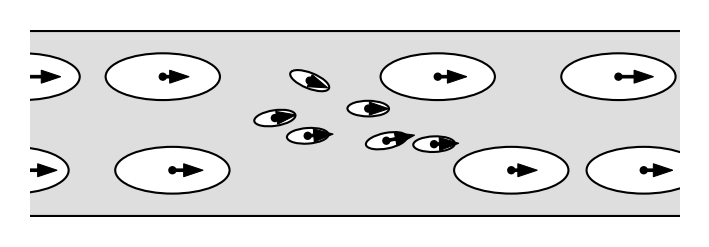

In [326]:
item = items[9]
xmin = 4.75
xmax = 29.75
t = 6900
fig, ax = plt.subplots(figsize=(5.5 * params.cm, 2 * params.cm), dpi=300)
ax.set_aspect("equal")
ring(t, n_cars, item[0], ax)
ax.set_xlim(xmin, xmax)
ax.tick_params(axis="both", direction="in", pad=0)
ax.axvspan(xmin, xmax, facecolor=grey, zorder=-1)
ax.set_axis_off()
plt.tight_layout(pad=0)
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(
    "./output/figures/frozen.pdf",
    format="pdf",
    transparent=True,
)